Imports argument vectors and the the created verb matrices and uses them to try a few composition methods on the RELPRON items.

In [1]:
import numpy as np
import numpy.linalg as la
from reach import Reach
import os
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing

In [4]:
#pathnames
relpron_path = './replron_translation.txt'
verbs_path = './verbmatrices/version3'
vectorspath = './tulkens-embeddings/160/sonar-160.txt'
resultspath = './compare-phrases-results.txt'

In [5]:
#import data
relpron_file = open(relpron_path,'r', encoding='latin-1')
items_raw = relpron_file.readlines()
relpron_file.close()

r = Reach(vectorspath, header=True)

verbmatrices = dict()
for verbfile in os.listdir(verbs_path):
    verbmatrices[verbfile[:-4]] = np.load(verbs_path+'/'+verbfile)


Vocab: 626711, Dim: 160


In [6]:
class Sentence:
    def __init__(self, string):
        key, self.propertystr = string[:-1].split(': ')
        self.relation, self.termN = key.split(' ')
        self.rel = self.relation[0]
        propertylst = self.propertystr.split(' ')
        self.headN = propertylst[0]
        self.argN = propertylst[2]
        v_inflected, v_root = propertylst[-1].split('/')
        self.V = v_root
        
items = dict()
for item in items_raw:
    sent = Sentence(item)
    if sent.termN not in items:
        items[sent.termN] = [sent]
    else:
        items[sent.termN].append(sent)

In [72]:
variance_control = True
mean_std = 0.08

class PhraseComposer:
    def __init__(self, sentence):
        """Load vectors and matrices for the phrase"""
        self.relation = sentence.rel
        self.arg_v = r.vector(sentence.argN)
        self.arg_v = self.Scale(self.arg_v)
        self.head_v = r.vector(sentence.headN)
        self.head_v = self.Scale(self.head_v)
        
        self.V_v = r.vector(sentence.V)
        self.VO_m = verbmatrices[sentence.V+'|O']
        self.VS_m = verbmatrices[sentence.V+'|S']
        
    def Scale(self, v):
        """Apply standard scaling to argument vector as was done in training."""
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.set_params(with_std=variance_control)
        v = scaler.fit_transform(v[:, np.newaxis])
        v = np.squeeze(v)
        if variance_control:
            v = mean_std * v
        return v
        
    
    def Compose(self, method):
        """Direct to proper composition method based on input string"""
        if method == 'vector addition':
            return self.VectorAddition()
        if method == 'full matrix':
            return self.FullMatrix()
        if method == 'V-arg matrix':
            return self.VArgMatrix()
        if method == 'V-head matrix':
            return self.VHeadMatrix()
        if method == 'full matrix wrong structure':
            return self.FullMatrixWrongStructure()
        
    def VectorAddition(self):
        return np.add(self.head_v, self.arg_v, self.V_v)

    def VHeadMatrix(self, relation=None):
        if not relation:
            relation = self.relation
        if relation == 'O':
            return np.dot(self.head_v, self.VO_m)
        else:
            return np.dot(self.head_v, self.VS_m)
    
    def VArgMatrix(self, relation=None):
        if not relation:
            relation = self.relation
        if relation == 'O':
            return np.dot(self.arg_v, self.VS_m)
        else:
            return np.dot(self.arg_v, self.VO_m)
    
    def FullMatrix(self):
        return np.add(self.VArgMatrix(), self.VHeadMatrix())
    
    def FullMatrixWrongStructure(self):
        if self.relation == 'O':
            relation = 'S'
        else:
            relation = 'O'
        return(np.add(self.VArgMatrix(relation), self.VHeadMatrix(relation)))

In [13]:
vectors_addition = list()
vectors_matrix = list()
indices = list()

for term in list(items.keys()):
    for sent in items[term]:
        if sent.V+'|O' in verbmatrices and sent.V+'|S' in verbmatrices:
            indices.append(sent)
            composer = PhraseComposer(sent)

            composed_matrix = composer.Compose('full matrix')
            composed_addition = composer.Compose('vector addition')

            vectors_addition.append(composed_addition)
            vectors_matrix.append(composed_matrix)

In [14]:
corr_m = np.corrcoef(np.vstack(vectors_matrix))
#corr_m = np.corrcoef(np.vstack(composed_matrix))

tags = [sent.termN for sent in indices]

df = pd.DataFrame(corr_m, index=tags, columns=tags)

print(df)

              sterrenwacht  sterrenwacht  evenwicht  evenwicht  evenwicht  \
sterrenwacht      1.000000      0.775468   0.561032   0.599104   0.555139   
sterrenwacht      0.775468      1.000000   0.635879   0.589270   0.701282   
evenwicht         0.561032      0.635879   1.000000   0.575191   0.783137   
evenwicht         0.599104      0.589270   0.575191   1.000000   0.594187   
evenwicht         0.555139      0.701282   0.783137   0.594187   1.000000   
arena             0.574375      0.531077   0.454703   0.417759   0.440514   
zand              0.505960      0.477908   0.374695   0.411940   0.405106   
zand              0.552040      0.587650   0.628727   0.599946   0.555535   
zand              0.729443      0.689430   0.513700   0.537951   0.547039   
zand              0.780190      0.749128   0.602086   0.557181   0.606082   
knop              0.744301      0.752306   0.691401   0.669788   0.701681   
moskee            0.928541      0.750218   0.604251   0.603141   0.583616   

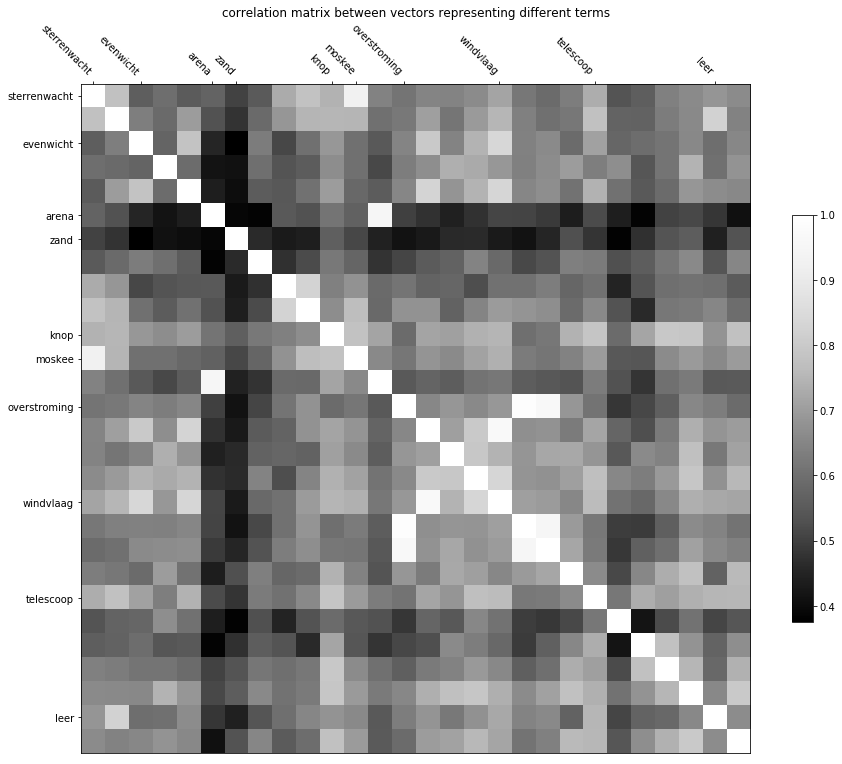

In [10]:
indices = []
ticks = []
lastindex = ''
for i in range(len(df.index)):
    if lastindex != df.index[i]:
        indices.append(df.index[i])
        lastindex = df.index[i]
        ticks.append(i)


fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(df.values, cmap="Greys_r")

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(indices)
ax.set_yticklabels(indices)
ax.xaxis.tick_top()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right")

#add legend
fig.colorbar(im, shrink=0.5)

ax.set_title("correlation matrix between vectors representing different terms")
plt.show()

In [15]:
corrs_sameterm = []
corrs_diffterms = []

for i in range(len(tags)):
    for j in range(len(tags)):
        if i != j:
            term_i = tags[i]
            term_j = tags[j]
            corr = df.values[i,j]
            if term_i == term_j:
                corrs_sameterm.append(corr)
            else:
                corrs_diffterms.append(corr)

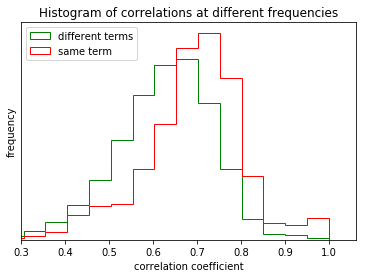

In [16]:
plt.hist([corrs_sameterm, corrs_diffterms], bins=25, histtype='step', color=['r','g'], density=True)
plt.yticks([])
plt.xlabel('correlation coefficient')
plt.ylabel('frequency')
plt.xlim(left=0.3)
plt.title('Histogram of correlations at different frequencies')
plt.legend(['different terms', 'same term'], loc='upper left')

In [17]:
sameterm_median = np.median(corrs_sameterm)
diffterms_median = np.median(corrs_diffterms)
print(sameterm_median)
print(diffterms_median)

0.7021797595711399
0.6347015973818353


In [73]:
#proper loop through all methods
datadict = dict()
methods = ['vector addition', 'full matrix', 'full matrix wrong structure', 'V-arg matrix', 'V-head matrix']

for method in methods:
    vectors = list()
    indices = list()

    for term in list(items.keys()):
        for sent in items[term]:
            if sent.V+'|O' in verbmatrices and sent.V+'|S' in verbmatrices:
                indices.append(sent)
                composer = PhraseComposer(sent)
                vectors.append(composer.Compose(method))
    
    datadict[method] = {'vectors': vectors, 'indices': indices}

results = dict()
    
for method in methods:
    corr_m = np.corrcoef(np.vstack(datadict[method]['vectors']))

    corrs_sameterm = []
    corrs_diffterms = []
    
    tags = [sent.termN for sent in datadict[method]['indices']]

    for i in range(len(tags)):
        for j in range(len(tags)):
            if i != j:
                term_i = tags[i]
                term_j = tags[j]
                corr = corr_m[i,j]
                if term_i == term_j:
                    corrs_sameterm.append(corr)
                else:
                    corrs_diffterms.append(corr)
    
    results[method] = {'same M': np.mean(corrs_sameterm), 'diff M': np.mean(corrs_diffterms)}
    results[method]['same SD'] = np.std(corrs_sameterm)
    results[method]['diff SD'] = np.std(corrs_diffterms)
    t, p = stats.ttest_ind(corrs_sameterm, corrs_diffterms, equal_var=False)
    results[method]['t'] = t
    results[method]['p'] = p
    
for method in sorted(results.keys()):
    for result in sorted(results[method].keys()):
        if result == 'p':
            p = results[method][result]
            if p < 0.001:
                print(method, 'p-value\t', '<0.001', sep='\t')
            else:
                print(method, 'p-value\t', p, sep='\t')
        else:
            print(method, result, results[method][result], sep='\t')

V-arg matrix	diff M	0.6049743190956788
V-arg matrix	diff SD	0.1215867945881496
V-arg matrix	p-value		<0.001
V-arg matrix	same M	0.6735888724902114
V-arg matrix	same SD	0.12296808992451325
V-arg matrix	t	20.990856305158324
V-head matrix	diff M	0.6541793184415774
V-head matrix	diff SD	0.10405844851247768
V-head matrix	p-value		<0.001
V-head matrix	same M	0.7340732422537193
V-head matrix	same SD	0.10668338519855802
V-head matrix	t	28.17549908764641
full matrix	diff M	0.6847630917025459
full matrix	diff SD	0.10081039902224732
full matrix	p-value		<0.001
full matrix	same M	0.7520747070631316
full matrix	same SD	0.0984634775895692
full matrix	t	25.709368639250226
full matrix wrong structure	diff M	0.6863550347473744
full matrix wrong structure	diff SD	0.09567968215128617
full matrix wrong structure	p-value		<0.001
full matrix wrong structure	same M	0.7483881449446746
full matrix wrong structure	same SD	0.09750571922335527
full matrix wrong structure	t	23.934643617826755
vector addition	diff 

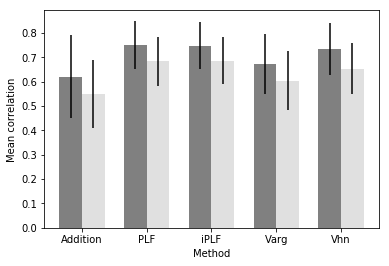

In [76]:
import matplotlib.pyplot as plt


N = len(methods)
sameMeans = [results[method]['same M'] for method in methods]
sameStd = [results[method]['same SD'] for method in methods]

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, sameMeans, width, color='grey', bottom=0, yerr=sameStd)



diffMeans = [results[method]['diff M'] for method in methods]
diffStd = [results[method]['diff SD'] for method in methods]

p2 = ax.bar(ind + width, diffMeans, width,
            color='#e0e0e0', bottom=0, yerr=diffStd)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Addition', 'PLF', 'iPLF', 'Varg', 'Vhn'])

plt.xlabel('Method')
plt.ylabel('Mean correlation')

#plt.figlegend((p1[0], p2[0]), ('Same term', 'Different terms'), loc='lower center')
ax.autoscale_view()

plt.show()



In [77]:
#save results to file
outfile = open(resultspath, 'w')
for method in sorted(results.keys()):
    for result in sorted(results[method].keys()):
        if result == 'p':
            p = results[method][result]
            if p < 0.0001:
                outfile.write(method+'\tp-value\t<0.0001')
            else:
                outfile.write(method+'\tp-value\t'+str(p))
            outfile.write('\n')
        else:
            outfile.write(method+'\t'+result+'\t'+str(results[method][result]))
            outfile.write('\n')
outfile.close()

In [41]:
#perform paired t-test to compare the results on the same term for different methods.

indices = datadict['full matrix']['indices']  #indices are identical for all methods

correlations = dict()

for method in methods:
    corr_m = np.corrcoef(np.vstack(datadict[method]['vectors']))

    corrs_sameterm = []
    corrs_diffterms = []
    
    tags = [sent.termN for sent in indices]
    
    for i in range(len(tags)):
        for j in range(len(tags)):
            if i != j:
                term_i = tags[i]
                term_j = tags[j]
                corr = corr_m[i,j]
                if term_i == term_j:
                    corrs_sameterm.append(corr)
                else:
                    corrs_diffterms.append(corr)
                    
    correlations[method] = corrs_sameterm
    #orders are identical so the ith item in the list correponds to the same pair of sentences for each methods

ttestresults = dict()
    
for method_1 in methods:
    for method_2 in methods:
        results = stats.ttest_rel(correlations[method_1], correlations[method_2])
        ttestresults[(method_1, method_2)] = results

comparisons = [('full matrix', 'full matrix wrong structure'), 
               ('full matrix wrong structure', 'V-head matrix'), 
               ('V-head matrix', 'V-arg matrix'),
               ('V-arg matrix', 'vector addition')]

for m1, m2 in comparisons:
    print(m1, m2, sep=', ')
    t,p = ttestresults[m1,m2]
    print(t,p, sep='\t')
    print()

full matrix, full matrix wrong structure
2.999531130663491	0.002750799521129279

full matrix wrong structure, V-head matrix
9.123542404133065	2.406327144785132e-19

V-head matrix, V-arg matrix
19.103347595764188	1.272336142274898e-72

V-arg matrix, vector addition
13.055155261779706	7.0262712394834225e-37

